In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.path as mpath
from matplotlib import rc
import matplotlib.pyplot as plt
import netCDF4 as nc 
import pandas as pd 
import xarray as xr
import seaborn as sns
import scipy
from xgcm import Grid
import matplotlib.animation as animation
from IPython.display import HTML
import cmocean
import cmasher
import h5py
from scipy.fft import fft, fftfreq
plt.rcParams.update({'font.size': 10})
from scipy import signal
%matplotlib inline
nanmasked = plt.get_cmap('turbo').copy()
nanmasked.set_bad('black')
nanmasked2 = plt.get_cmap('RdBu').copy()
nanmasked2.set_bad('black')
import os
# from dask.distributed import Client
# import dask
# client = Client()
# client
from dask.diagnostics import ProgressBar

In [ ]:
# open the 5 year dataset
ds = xr.open_mfdataset('/scratch/gpfs/CDEUTSCH/wchu/CEFI-regional-MOM6/exps/NWA12.COBALT/OUTPUT/control/**/*ocean_daily_budgets*.nc',chunks='auto',engine='h5netcdf',combine='nested',concat_dim='time',decode_timedelta='CFTimedeltaCoder')
ds = ds.isel(xh=slice(0,601),yh=slice(0,343))#,xq=slice(0,601),yq=slice(0,343))

# ## full static on the native full grid cropped to region
data_path = '/scratch/gpfs/CDEUTSCH/wchu/CEFI-regional-MOM6/exps/NWA12.COBALT/OUTPUT/control/1997/19970101.ocean_static.nc'
static = xr.open_dataset(data_path,chunks='auto')
static = static.isel(xh=slice(0,601),yh=slice(0,343),xq=slice(0,601),yq=slice(0,343))
print('data loaded!')

data loaded!


In [3]:
### defining xgcm grid for best practices 

ds['dxt'] = static['dxt'].fillna(0.)
ds['dyt'] = static['dyt'].fillna(0.)
ds['areacello'] = static['areacello'].fillna(0.)

metrics = {
    ('X',): ['dxt'], # X distances
    ('Y',): ['dyt'], # Y distances
    ('X', 'Y'): ['areacello'] # Areas
}

coords={'X': {'center': 'xh', 'right': 'xq'},
        'Y': {'center': 'yh', 'right': 'yq'},
       'time': {'center':'time'}}

# ds = xr.merge([ds,static]) # we have to merge so that the time dimension will be processed correctly
ds = ds.unify_chunks()

grid = Grid(ds, coords=coords, metrics=metrics, periodic=[])#not periodic because it's a regional model, periodic=['X'])

### O2 - slope normal alignment (Fig ??)

Calculate normal vectors:

In [4]:
h = static.depth_ocean.fillna(0)
nx = grid.derivative(grid.interp(h,['X']),'X')#.persist() # [m] 
ny = grid.derivative(grid.interp(h,['Y']),'Y')#.persist() # [m] 
nz = -xr.ones_like(h)
norm = np.sqrt(nx**2 + ny**2 + nz**2)#.persist()
nx = (nx/norm)#.persist()
ny = (ny/norm)#.persist()
nz = (nz/norm)#.persist()

/home/wc4720/.conda/envs/xdefault/lib/python3.13/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(
/home/wc4720/.conda/envs/xdefault/lib/python3.13/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(
/home/wc4720/.conda/envs/xdefault/lib/python3.13/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names t

Get the closest zl index for the seafloor, making sure it's above the actual seafloor depth. 

In [5]:
### making the depth index
depth_ind = np.abs(ds.zl- static.depth_ocean.fillna(0)).argmin(dim='zl').compute()
depth_ind = xr.where((static.depth_ocean>=ds.zl.isel(zl=depth_ind)),depth_ind,depth_ind-1)
depth_ind = depth_ind.where(np.isnan(static.depth_ocean)==0,0).astype('int').compute()
# depth_ind.plot(x='xh',y='yh',cmap='turbo')

Calculate oxygen derivatives, scale by characteristic lengths L=9250 m (approximate width of a grid cell) and Z=20 m (average-ish height of a grid cell).  
  
  Note that we do not have to divide by dz because xarray automatically takes into account the intervals of the dimension along which you're calculating the derivative. We do it for the horizontal case since the latitude and longitude are in degree units, so they are not uniform throughout the domain.  

In [6]:
# ### measuring the o2-h alignment
test = 1e6*ds.o2 # mumol/kg
o2_x = grid.derivative(grid.interp(test,['X']),'X') #convert to mumol then nondimensionalize distance using L=9250m [mumol]
o2_x_bound = o2_x.isel(zl=depth_ind) # select index before value so it doesn't go into land
o2_y = grid.derivative(grid.interp(test,['Y']),'Y') # convert to mumol then nondimensionalize distance using L=9250m [mumol]
o2_y_bound = o2_y.isel(zl=depth_ind) # select index before value so it doesn't go into land
o2_z = (test.differentiate('zl')) # to account for difference in depth levels, choose Z = 20 as nondim, xr.differentiate automatically accounts for difference in depth levles
o2_z_bound = o2_z.isel(zl=depth_ind)
divo2h = (o2_x_bound*nx + o2_y_bound*ny + o2_z_bound*nz).compute()

/home/wc4720/.conda/envs/xdefault/lib/python3.13/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(
/home/wc4720/.conda/envs/xdefault/lib/python3.13/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(
/home/wc4720/.conda/envs/xdefault/lib/python3.13/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names t

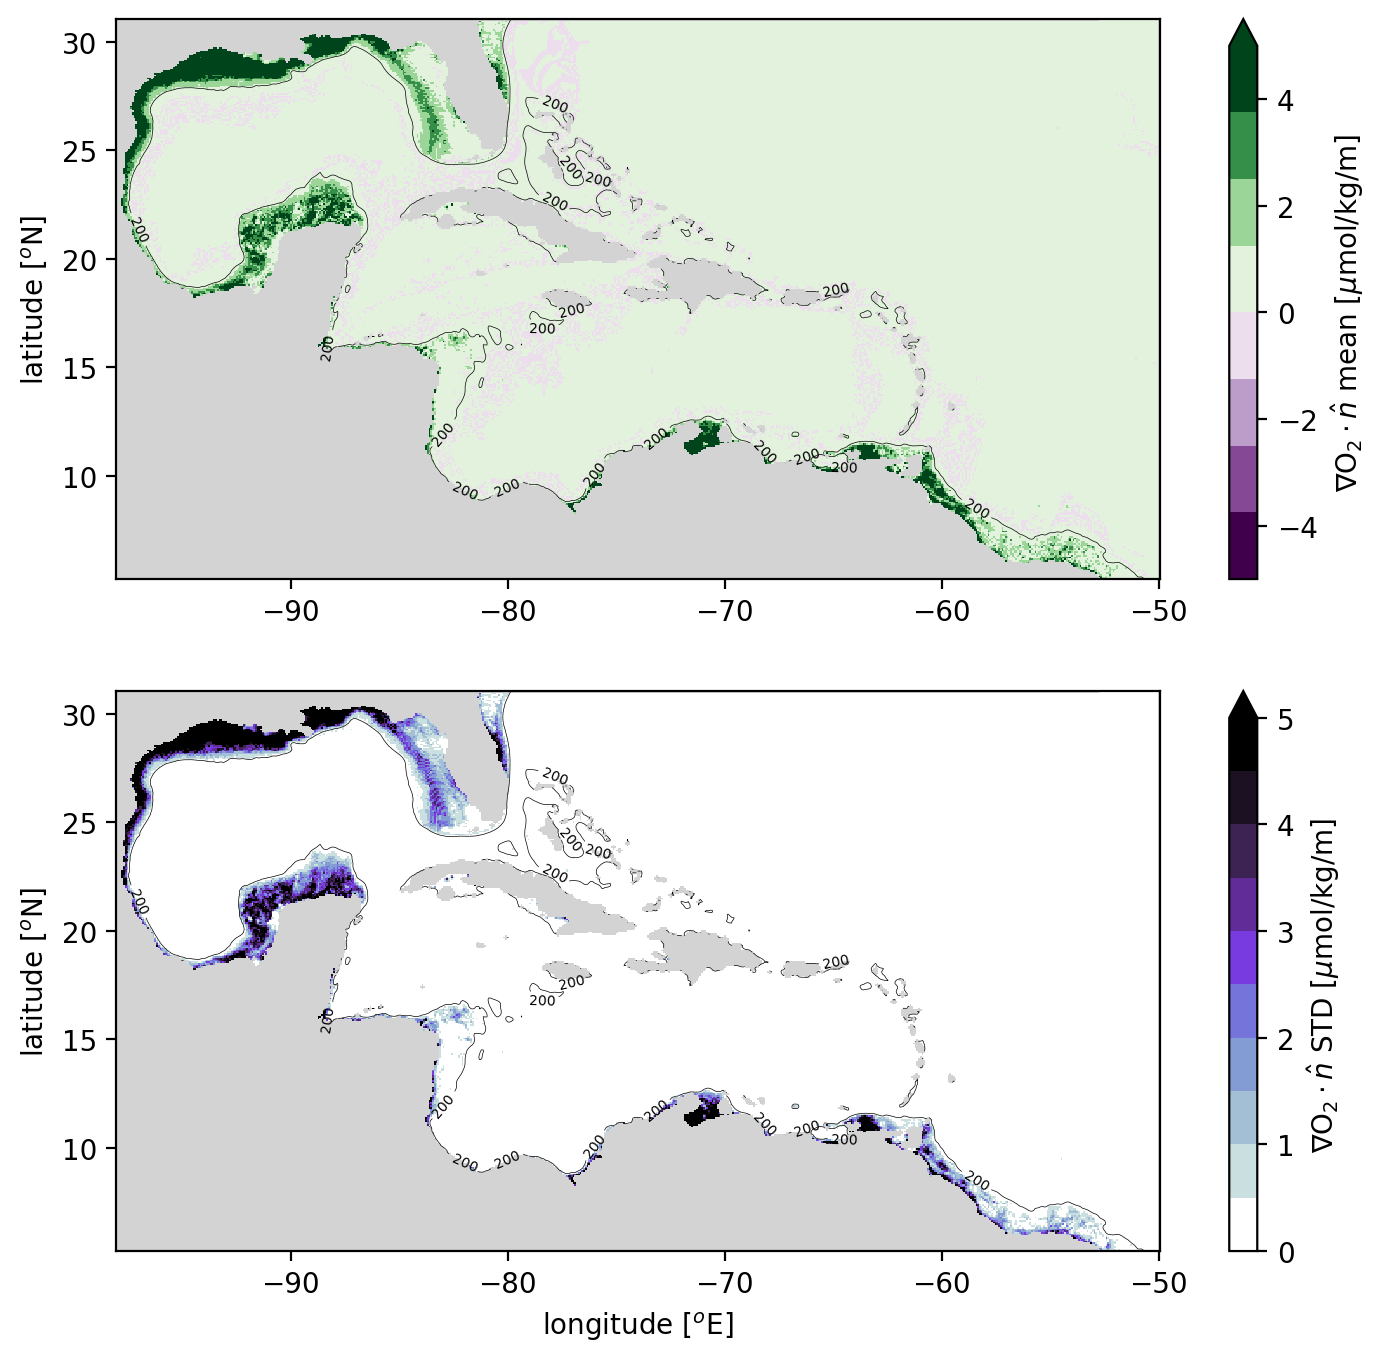

In [18]:
# divo2h_var = divo2h.var('time').persist()
# divo2h_mean = divo2h.mean('time')
# divo2h_std = divo2h.std('time')

fig, ax = plt.subplots(2, 1, figsize=(9,8),dpi=200) #,sharex=True
nanmasked = plt.get_cmap('PRGn',8).copy()
nanmasked.set_bad('lightgray')
divo2h_mean.plot(x='xh',y='yh',cmap=nanmasked,ax=ax[0],vmin=-5,vmax=5,cbar_kwargs={'label':r'$\nabla$O$_2 \cdot \hat{n}$ mean [$\mu$mol/kg/m]'})  #vmin=-100,vmax=100
nanmasked = plt.get_cmap('cmr.amethyst_r',10).copy()
nanmasked.set_bad('lightgray')
divo2h_std.plot(x='xh',y='yh',cmap=nanmasked,ax=ax[1],vmin=0,vmax=5,cbar_kwargs={'label':r'$\nabla$O$_2 \cdot \hat{n}$ STD [$\mu$mol/kg/m]'}) #.where(divo2h_mean>=0.005)
CS = static.depth_ocean.plot.contour(x='xh',y='yh',levels=[200],colors='k',ax=ax[0],linewidths=0.25)
ax[0].clabel(CS, fontsize=5)
CS = static.depth_ocean.plot.contour(x='xh',y='yh',levels=[200],colors='k',ax=ax[1],linewidths=0.25)
ax[1].clabel(CS, fontsize=5)
ax[1].set_xlabel('longitude [$^o$E]')
ax[0].set_xlabel('')
ax[0].set_ylabel('latitude [$^o$N]')
ax[1].set_ylabel('latitude [$^o$N]')
ax[0].set_aspect('equal')
ax[1].set_aspect('equal')

In [15]:
divo2h.to_netcdf('/scratch/gpfs/CDEUTSCH/wchu/CEFI-regional-MOM6/exps/NWA12.COBALT/ANALYSIS/divo2h_noND.nc')